In [26]:
import collections
from etils import epath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
from tqdm import tqdm
import os
import json
import pathlib
import seaborn as sns

In [27]:
# path_to_working_dir = pathlib.Path('/mnt/fscompute_shared/agile_modeling/experiments_paper/output')
# datasets_to_include = ['grafton_deployment', 'texel']

path_to_working_dir = pathlib.Path('/home/reindert/Valentin_REVO/surfperch_toshare/eval_texel Outputs/september 2024/final_results/')
datasets_to_include = ['texel']


In [28]:
final_results = pd.DataFrame(columns=['sound_name', 'model', 'picking_strategy', 'ratio', 'n_samples', 'split', 'value', 'metric'])
metrics = ['precision', 'recall', 'auc_roc', 'auc_pr']
for dataset_name in datasets_to_include:
    dataset_folder = path_to_working_dir.joinpath(dataset_name)
    for model_folder in dataset_folder.glob('*'): 
        if model_folder.is_dir(): 
            results_folder = model_folder.joinpath('results')
            if results_folder.exists(): 
                for results_json in results_folder.glob('*'): 
                    if not results_json.is_dir():
                        sound_name, model_name, strategy, ratio, _ = results_json.name.split('_')
                        df_results = pd.read_json(str(results_json))
                        for n_samples in df_results.columns: 
                            for split in df_results.index: 
                                results = df_results.loc[split][n_samples]
                                for metric in metrics: 
                                    
                                    df_i = pd.DataFrame({'sound_name': sound_name, 'model': model_name, 'picking_strategy': strategy, 'ratio': ratio, 
                                                     'n_samples': n_samples, 'split': split, 'value': results[metric], 'metric': metric})
                                
                                    if final_results is None:
                                        final_results = df_i
                                    else:
                                        final_results = pd.concat([final_results, df_i], ignore_index=True)

/tmp/ipykernel_3393/142955972.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, df_i], ignore_index=True)


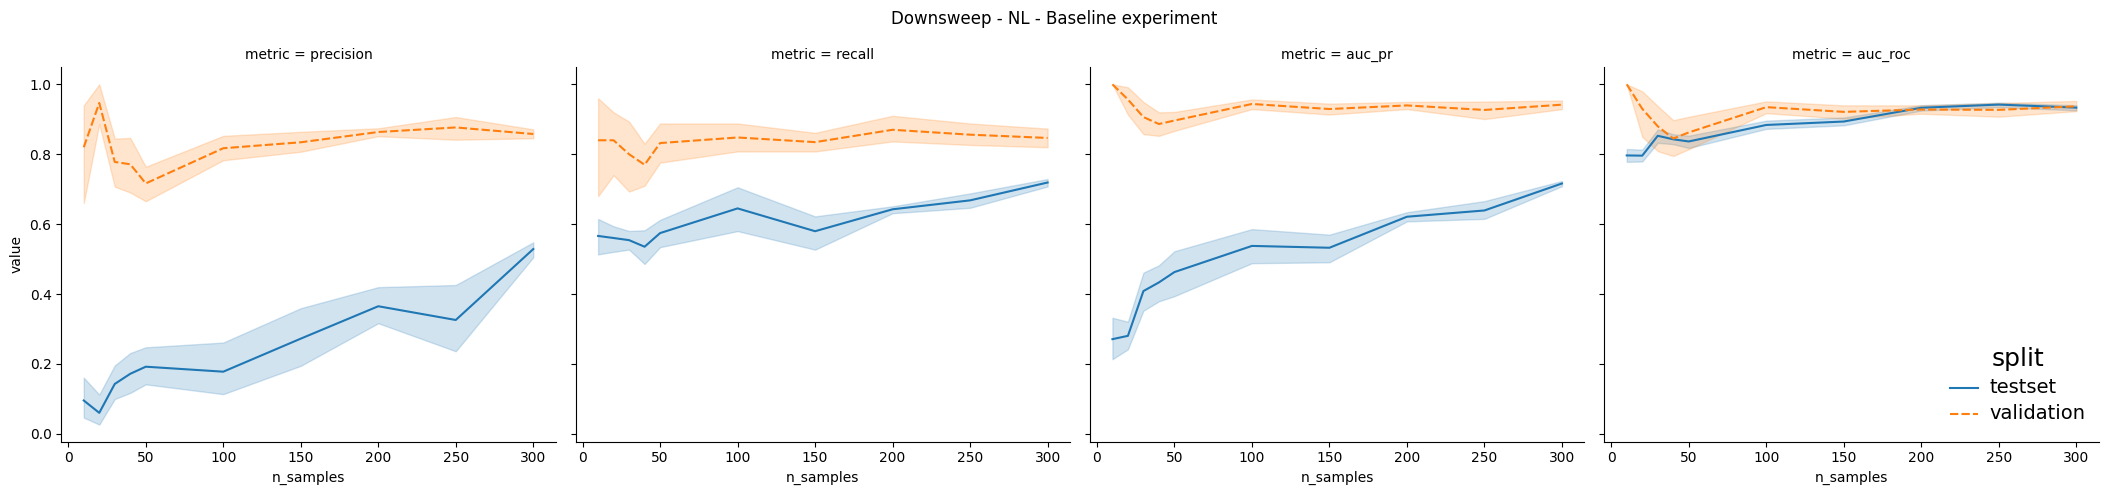

In [62]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    # Plotting baseline
    filtered_sound_results = sound_results.loc[(sound_results.ratio == '11') & (sound_results.picking_strategy == 'hockey')]

    # order df to have testset first
    filtered_sound_results = filtered_sound_results.sort_values(by=['split'])

    plot = sns.relplot(
        data=filtered_sound_results,
        style="split",
        x="n_samples", 
        y="value", 
        col="metric", 
        hue="split", 
        kind="line",
        col_order=['precision', 'recall', 'auc_pr', 'auc_roc'], 
    )
    plt.suptitle(f'{sound_name.capitalize()} - NL - Baseline experiment')
    plt.tight_layout()
    leg = plot._legend
    leg.set_bbox_to_anchor((0.99, 0.22))
    plt.setp(leg.get_texts(), fontsize=14)
    plt.setp(leg.get_title(), fontsize=18)
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_baseline.png'))
    plt.show()

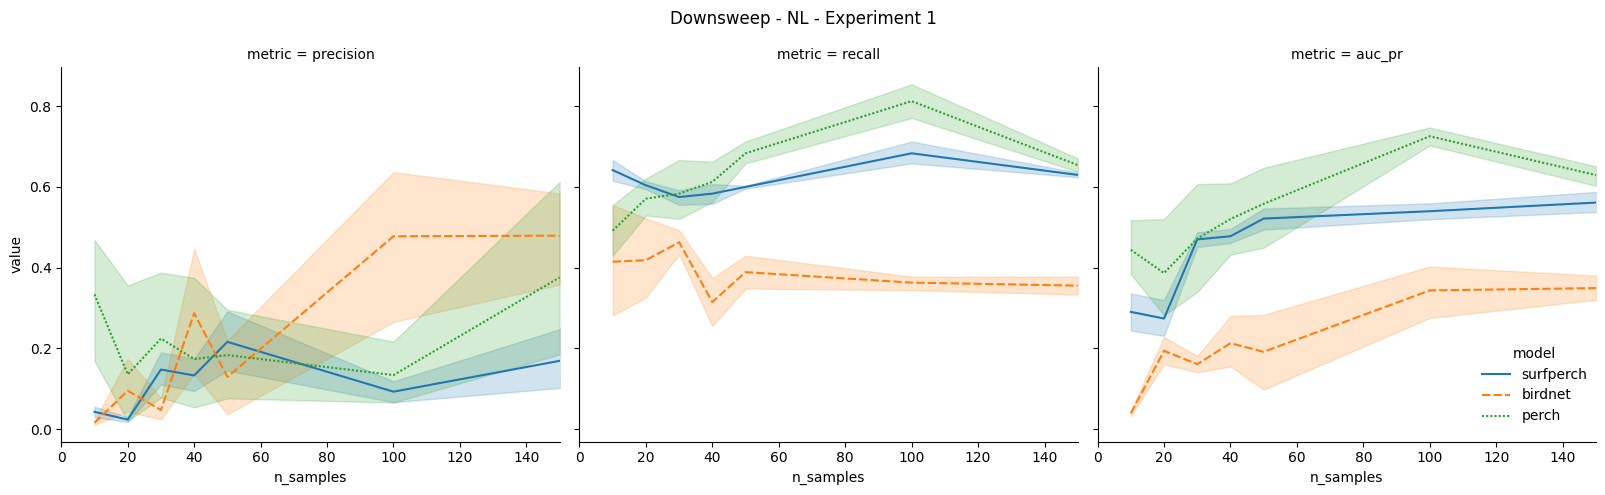

In [63]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    # Experiment 1: model 
    filtered_sound_results = sound_results.loc[(sound_results.ratio == '11')
                                 & (sound_results.picking_strategy == 'hockey')
                                 & (sound_results.split == 'testset')
                                 & (sound_results.metric != 'auc_roc')]
    plot = sns.relplot(
        data=filtered_sound_results, style="model", x="n_samples", y="value", col="metric", hue="model", kind="line",
        col_order=['precision', 'recall', 'auc_pr']
    )
    plt.suptitle(f'{sound_name.capitalize()} - NL - Experiment 1')
    plt.tight_layout()
    plt.xlim(0, 150)
    leg = plot._legend
    leg.set_bbox_to_anchor((0.99, 0.22))
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}exp1.png'))
    plt.show()

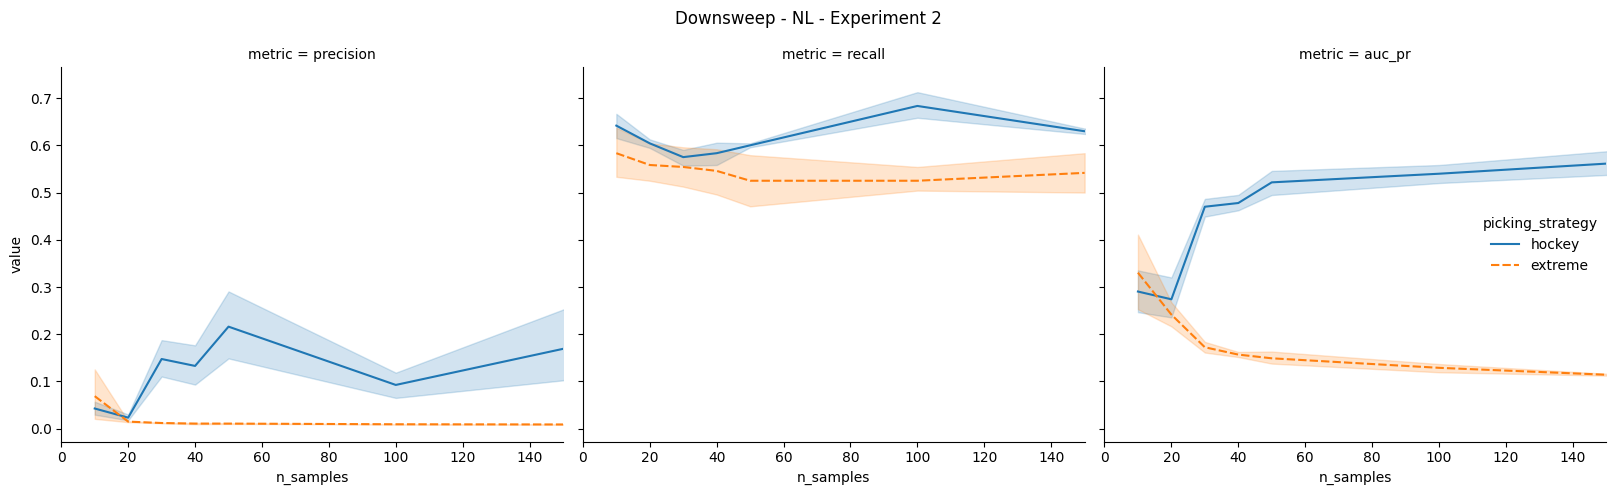

In [ ]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    
    # Experiment 2: strategy 
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch') 
                                                & (sound_results.ratio == '11')
                                                & (sound_results.split == 'testset')
                                                & (sound_results.metric != 'auc_roc')]
    # Order by picking strategy
    filtered_sound_results = filtered_sound_results.sort_values(by=['picking_strategy'], ascending=False)
    
    plot = sns.relplot(data=filtered_sound_results, style="picking_strategy", x="n_samples", y="value", col="metric", hue="picking_strategy", kind="line",
                        col_order=['precision', 'recall', 'auc_pr']
    )

    plt.suptitle(f'{sound_name.capitalize()} - NL - Experiment 2')
    plt.tight_layout()
    plt.xlim(0, 150)
    leg = plot._legend
    leg.set_bbox_to_anchor((0.99, 0.5))
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp2.png'))
    plt.show()

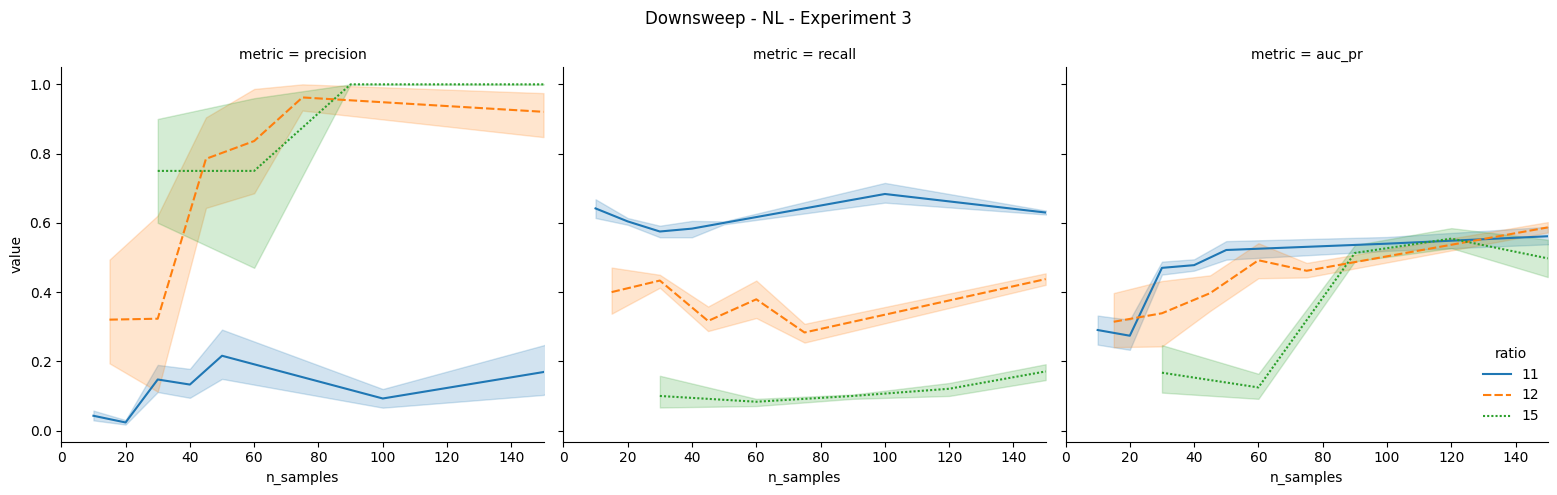

In [76]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    # Experiment 1: model 
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch')
                                 & (sound_results.picking_strategy == 'hockey')
                                 & (sound_results.split == 'testset')
                                 & (sound_results.metric != 'auc_roc')]
    plot = sns.relplot(
        data=filtered_sound_results, style="ratio", x="n_samples", y="value", col="metric", hue="ratio", kind="line",
        col_order=['precision', 'recall', 'auc_pr']
    )
    plt.suptitle(f'{sound_name.capitalize()} - NL - Experiment 3')
    plt.tight_layout()
    plt.xlim(0, 150)
    leg = plot._legend
    leg.set_bbox_to_anchor((0.99, 0.22))
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}exp3.png'))
    plt.show()

## Original code - all figures

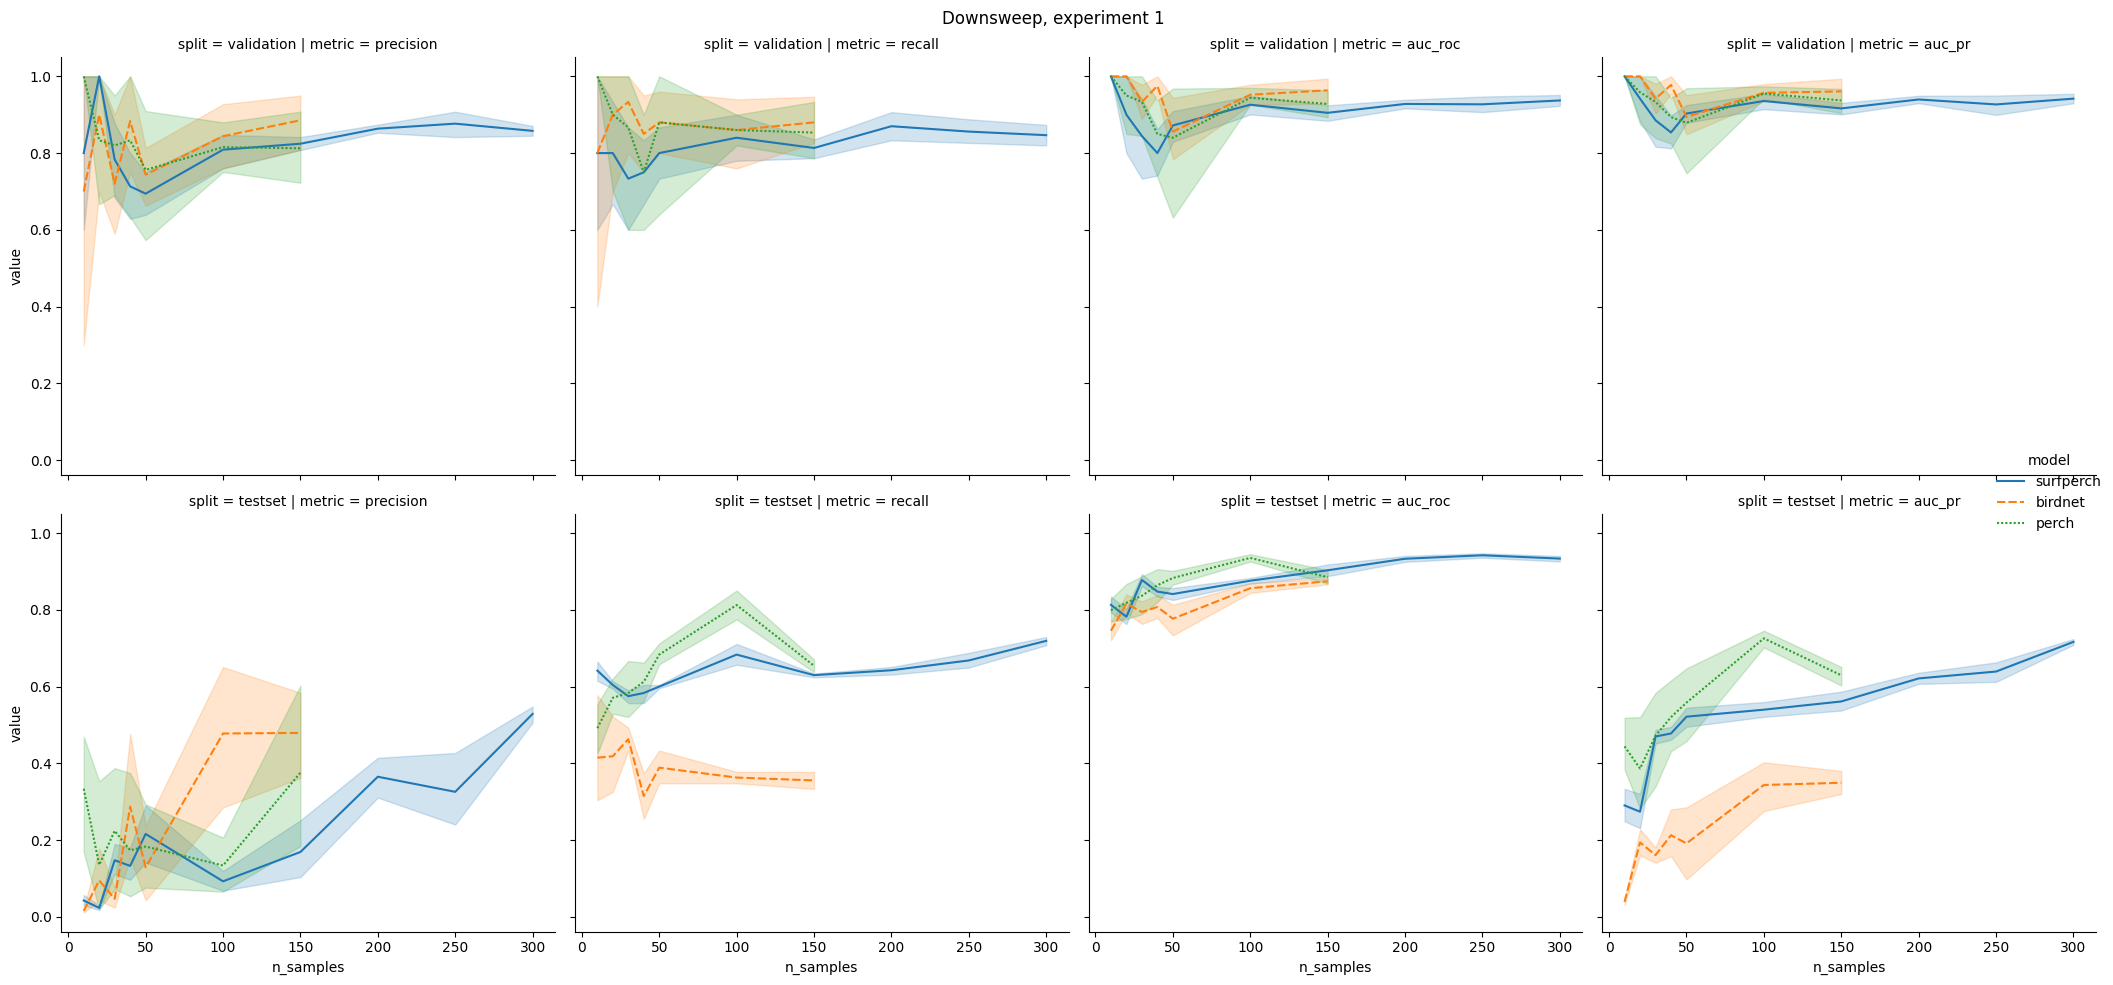

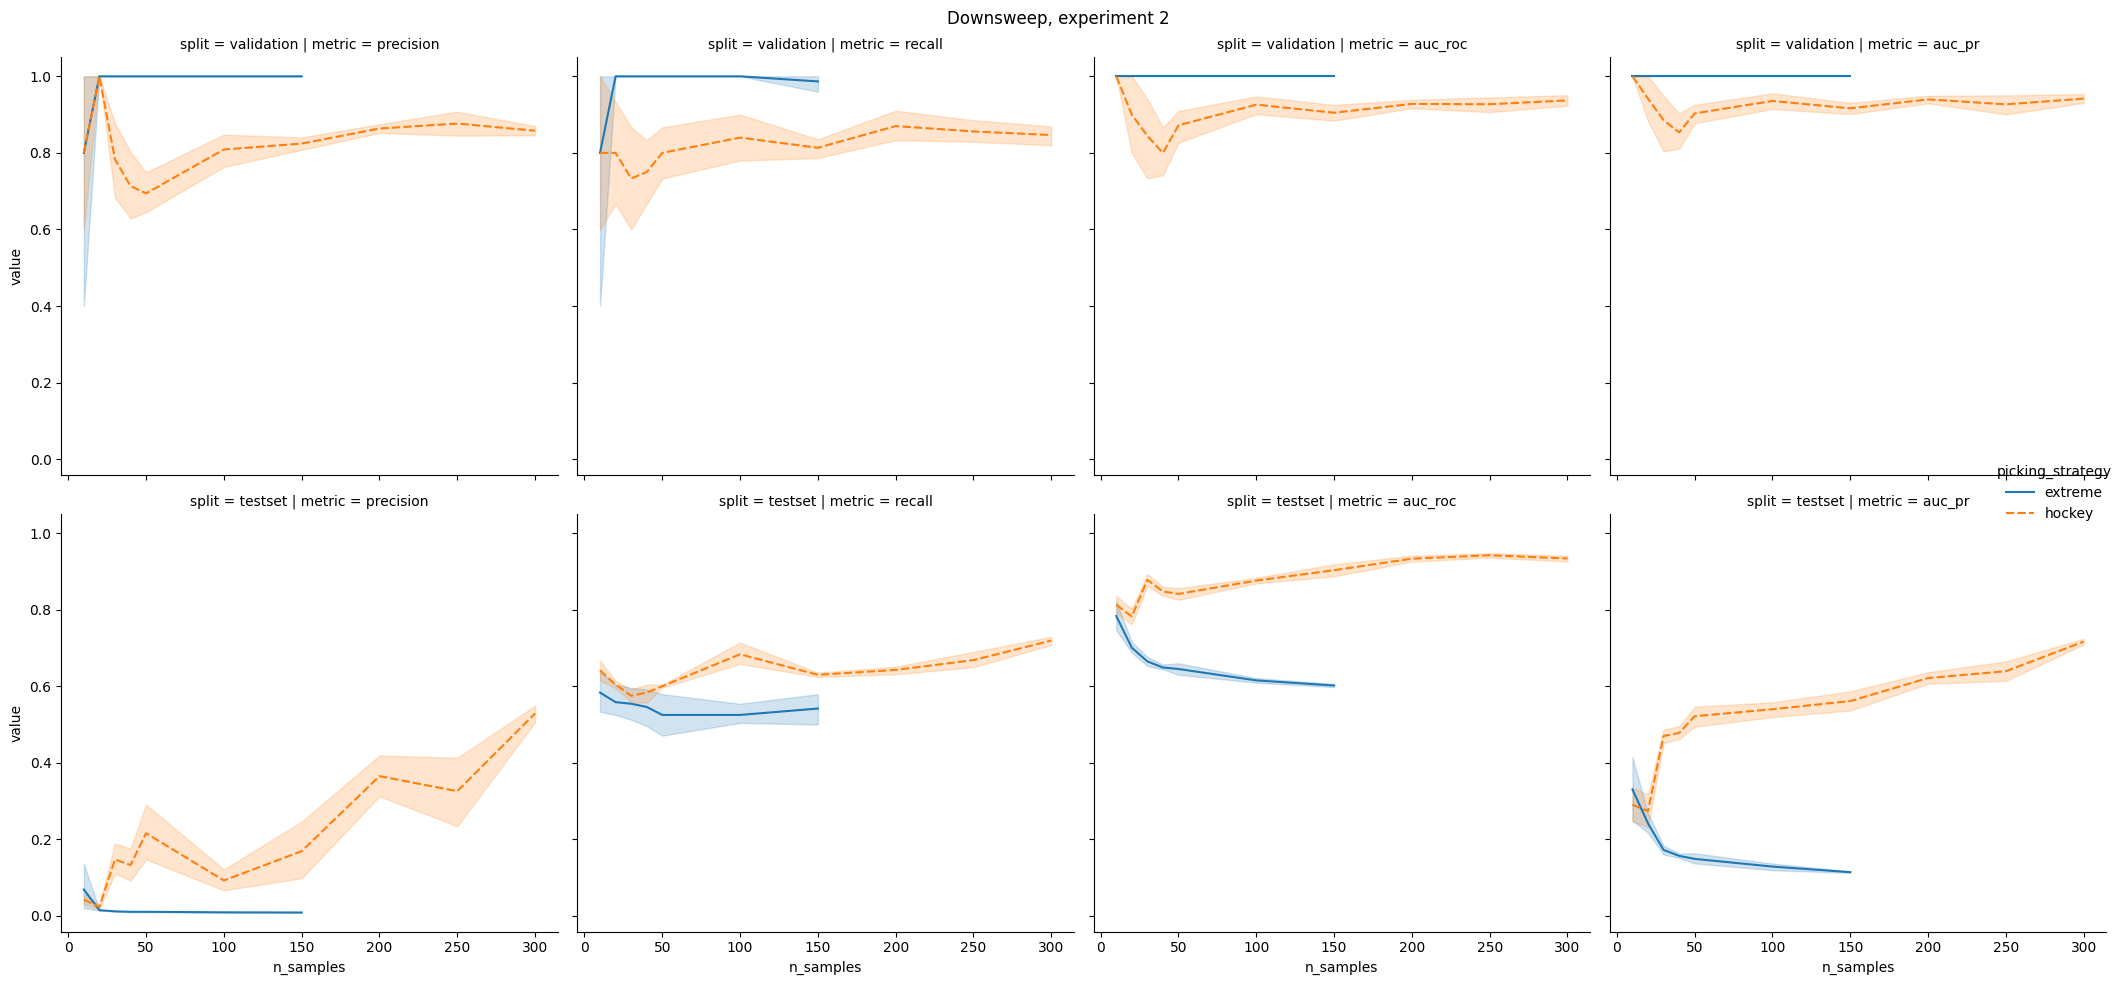

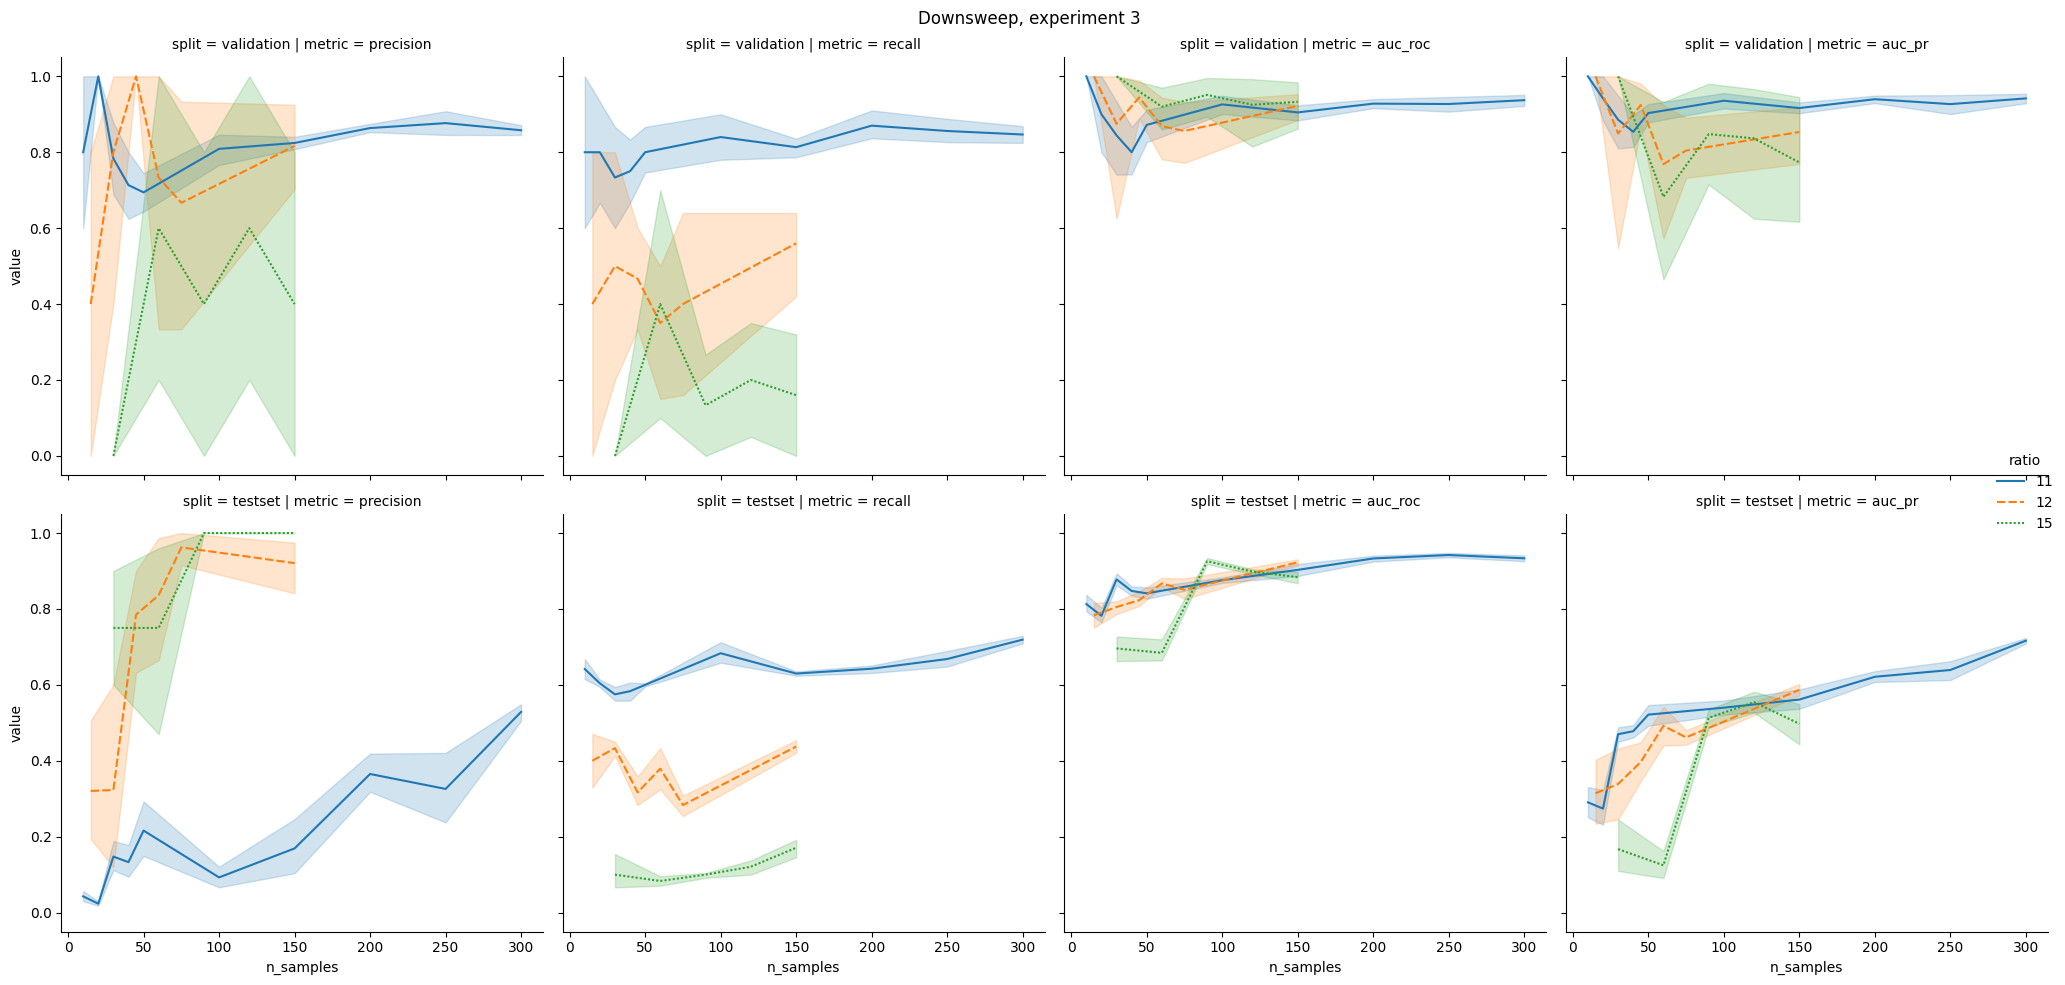

In [77]:
for sound_name, sound_results in final_results.groupby('sound_name'): 
    # Experiment 1: model 
    filtered_sound_results = sound_results.loc[(sound_results.ratio == '11') & (sound_results.picking_strategy == 'hockey')]
    sns.relplot(
        data=filtered_sound_results, style="model", row='split', x="n_samples", y="value", col="metric", hue="model", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 1')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp1.png'))
    plt.show()

    # # Experiment 2: picking strategy
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch') & (sound_results.ratio == '11')]
    sns.relplot(
        data=filtered_sound_results, style="picking_strategy", row='split', x="n_samples", y="value", col="metric", hue="picking_strategy", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 2')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp2.png'))
    plt.show()

    # Experiment 2: picking strategy
    filtered_sound_results = sound_results.loc[(sound_results.model == 'surfperch') & (sound_results.picking_strategy == 'hockey')]
    sns.relplot(
        data=filtered_sound_results, style="ratio", row='split', x="n_samples", y="value", col="metric", hue="ratio", kind="line", row_order=["validation", "testset"]
    )
    plt.suptitle(f'{sound_name.capitalize()}, experiment 3')
    plt.tight_layout()
    plt.savefig(path_to_working_dir.joinpath('plots', f'{sound_name}_exp3.png'))
    plt.show()
